<a href="https://colab.research.google.com/github/ilyasbrhm/dicoding/blob/main/Proyek_Analisis_Sentimen_Ilyas_Imam_Ibrahim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [6]:
!pip install keras tensorflow

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.layers import Bidirectional, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D

## Kriteria 1: Data merupakan hasil scraping secara mandiri

In [8]:
df = pd.read_csv("https://raw.githubusercontent.com/ilyasbrhm/Dataset/refs/heads/main/shopeepay.csv" )
df.head()

,content,score
0,sangat baik,5
1,ShopeePay memudahkan pembayaran saat berbelanja,4
2,"suka banget. shopeepay. shopeeleter, sheabank....",5
3,good jooob,5
4,mantap pay,5


## Kriteria 2: Melakukan tahapan ekstraksi fitur dan pelabelan data


In [9]:
print("Jumlah Baris dan Kolom")
print(df.shape)

print("Jenis Data:")
print(df.dtypes)

Jumlah Baris dan Kolom
(58781, 2)
Jenis Data:
content    object
score       int64
dtype: object


In [10]:
print("Data yang Hilang")
print(df.isnull().sum())

Data yang Hilang
content    0
score      0
dtype: int64


In [11]:
print("Analisis Distribusi")
print(df.describe())


Analisis Distribusi
              score
count  58781.000000
mean       4.412701
std        1.293421
min        1.000000
25%        5.000000
50%        5.000000
75%        5.000000
max        5.000000


<ipython-input-12-0c200a95631f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='score', data=df, palette='viridis')


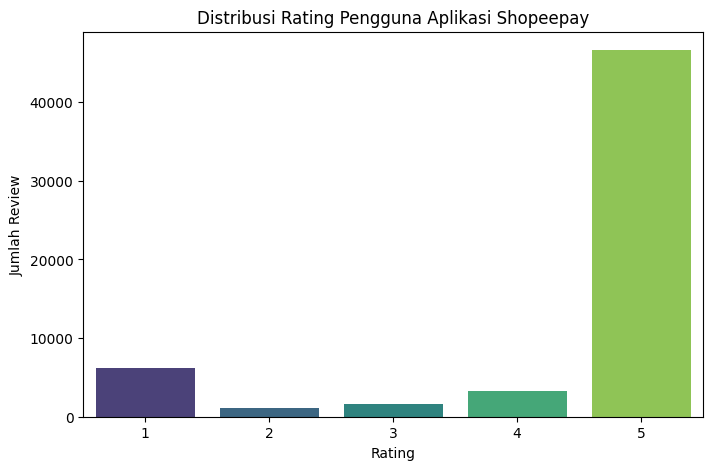

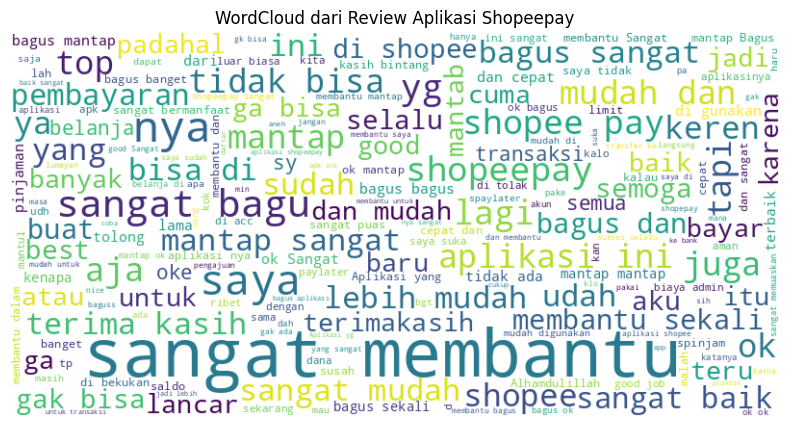

In [12]:
plt.figure(figsize=(8,5))
sns.countplot(x='score', data=df, palette='viridis')
plt.title('Distribusi Rating Pengguna Aplikasi Shopeepay')
plt.xlabel('Rating')
plt.ylabel('Jumlah Review')
plt.show()

df['review_length'] = df['content'].apply(len)

text = " ".join(review for review in df['content'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud dari Review Aplikasi Shopeepay')
plt.show()

<ipython-input-13-1202689920d5>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='pastel')


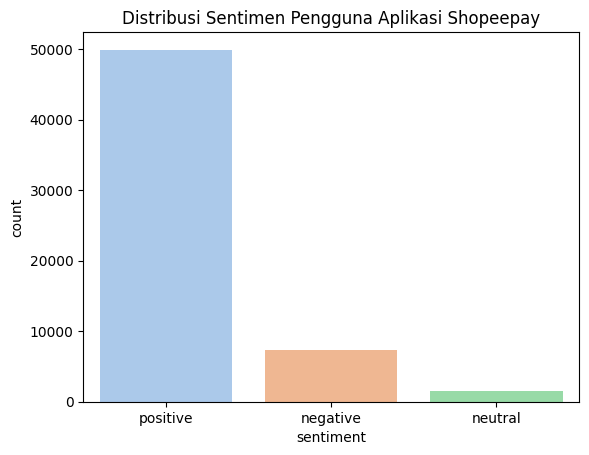

sentiment
positive    49913
negative     7309
neutral      1559
Name: count, dtype: int64


In [13]:
def label_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

df['sentiment'] = df['score'].apply(label_sentiment)

sns.countplot(x='sentiment', data=df, palette='pastel')
plt.title('Distribusi Sentimen Pengguna Aplikasi Shopeepay')
plt.show()
print(df['sentiment'].value_counts())

In [14]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # hapus URL
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # hapus simbol/angka
    text = text.lower()  # ke lowercase semua
    tokens = text.split()  # tokenisasi
    tokens = [t for t in tokens if t not in stop_words]  # hapus stopwords
    tokens = [stemmer.stem(t) for t in tokens]  # stemming
    return " ".join(tokens)

df['cleaned_text'] = df['content'].astype(str).apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['cleaned_text'])

# Label encoding untuk y
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df['sentiment'])  # y untuk ML
y_dl_cat = to_categorical(y, num_classes=3)

In [16]:
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])

maxlen = 100  # atau disesuaikan dengan panjang rata-rata komentar
X_pad = pad_sequences(sequences, maxlen=maxlen, padding='post')

# Encoding label (sama seperti di atas, bisa dipakai ulang)
y = le.transform(df['sentiment'])  # y untuk Deep Learning


## Kriteria 3: Menggunakan algoritma pelatihan machine learning

Skema Pelatihan 1

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_dl_cat, test_size=0.2, random_state=1)

model1 = Sequential([
    Embedding(10000, 64, input_length=100),  # maxlen = 100
    LSTM(64),
    Dense(3, activation='softmax')
])

model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history1 = model1.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
735/735 ━━━━━━━━━━━━━━━━━━━━ 71s 92ms/step - accuracy: 0.8466 - loss: 0.5212 - val_accuracy: 0.8526 - val_loss: 0.4849
Epoch 2/5
735/735 ━━━━━━━━━━━━━━━━━━━━ 86s 97ms/step - accuracy: 0.8466 - loss: 0.5009 - val_accuracy: 0.8526 - val_loss: 0.4849
Epoch 3/5
735/735 ━━━━━━━━━━━━━━━━━━━━ 76s 90ms/step - accuracy: 0.8494 - loss: 0.4956 - val_accuracy: 0.8526 - val_loss: 0.4843
Epoch 4/5
735/735 ━━━━━━━━━━━━━━━━━━━━ 103s 119ms/step - accuracy: 0.8484 - loss: 0.4977 - val_accuracy: 0.8526 - val_loss: 0.4845
Epoch 5/5
294/735 ━━━━━━━━━━━━━━━━━━━━ 36s 84ms/step - accuracy: 0.8482 - loss: 0.5000

Evaluasi Skema pelatihan 1

In [ ]:
loss, accuracy = model1.evaluate(X_test, y_test)
print(f"Akurasi Model 1 (Skema 1): {accuracy*100:.2f}%")


Skema Pelatihan 2

In [ ]:

# Split data 70/30
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_pad, y_dl_cat, test_size=0.3, random_state=2)

# Model
model2 = Sequential([
    Embedding(10000, 128, input_length=100),  # Sesuaikan dengan maxlen
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training
history2 = model2.fit(X_train2, y_train2, epochs=5, batch_size=64, validation_data=(X_test2, y_test2))


Evaluasi Skema pelatihan 2

In [ ]:
loss2, acc2 = model2.evaluate(X_test2, y_test2)
print(f"Akurasi Model 2 (Skema 2): {acc2*100:.2f}%")


Skema Pelatihan 3

In [ ]:


# Split data untuk Skema 3 (contoh: 80/20 lagi)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_pad, y_dl_cat, test_size=0.2, random_state=3)

# Placeholder Word2Vec (bisa kamu ganti dengan Word2Vec asli jika sudah ada)
embedding_matrix = np.random.rand(10000, 300)

# Model CNN + LSTM
model3 = Sequential([
    Embedding(10000, 300, weights=[embedding_matrix], input_length=100, trainable=False),  # Sesuaikan input_length
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(64),
    Dense(3, activation='softmax')
])

model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training
history3 = model3.fit(X_train3, y_train3, epochs=5, batch_size=64, validation_data=(X_test3, y_test3))


Evaluasi Skema pelatihan 3

In [ ]:
loss3, acc3 = model3.evaluate(X_test3, y_test3)
print(f"Akurasi Model 3 (Skema 3): {acc3*100:.2f}%")


## inference atau testing

In [ ]:
def predict_sentiment(text, model):
    # Preprocessing
    text_clean = clean_text(text)
    seq = tokenizer.texts_to_sequences([text_clean])
    padded = pad_sequences(seq, maxlen=100, padding='post')  # sesuaikan dengan maxlen yang kamu gunakan

    # Prediksi
    pred = model.predict(padded)
    class_idx = np.argmax(pred, axis=1)[0]

    # Mapping index ke label
    sentiment_label = le.inverse_transform([class_idx])[0]

    return sentiment_label


In [ ]:
# Misalnya kita ingin testing model1 (Skema 1)
print(predict_sentiment("Saya kecewa dengan layanan ini", model3))  # Output: negatif
print(predict_sentiment("Aplikasinya cukup oke, tapi kadang error", model3))  # Output: netral
print(predict_sentiment("Sangat puas! Fitur lengkap dan cepat", model3))  # Output: positif


In [ ]:
!pip install pipreqs
!pipreqs /content --force
